In [9]:
import os
import warnings
from collections import Counter

import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from konlpy.tag import Okt, Mecab
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [10]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## 1. 데이터 로딩 (훈련데이터. 테스트 데이터)

In [11]:
# 훈련데이터와 테스트 데이터를 로딩
train_data = pd.read_table('~/aiffel/workplace/E-06_Movie_Review/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/workplace/E-06_Movie_Review/sentiment_classification/data/ratings_test.txt')

In [12]:
# train 데이터 확인
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
# test 데이터 확인
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [64]:
# 데이터의 개수 확인
print("train set: {}개".format(len(train_data)))
print("test set: {}개".format(len(test_data)))

train set: 150000개
test set: 50000개


<AxesSubplot:>

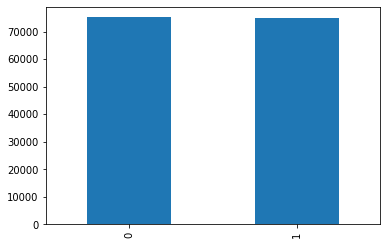

In [14]:
# 라벨들을 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if word not in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [14]:
# index와 word 항목 전환
index_to_word = {index:word for word, index in word_to_index.items()}

In [15]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [69]:
# 샘플개수 확인
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [70]:
# decoding
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [16]:
# 텍스트데이터 문장길이의 리스트를 생성
total_data_text = list(x_train) + list(x_test)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


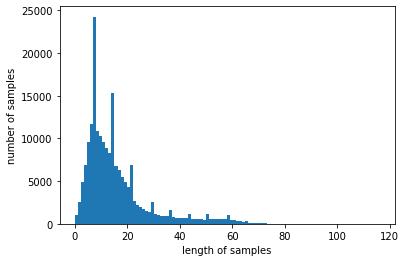

In [17]:
# 문장길이의 평균값, 최대값, 표준편차를 계산
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
plt.clf()

plt.hist([len(s) for s in total_data_text], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
# padding 
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [20]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

## LSTM

In [21]:
# model 설계
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [22]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [23]:
# 모델 학습
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 4s 25ms/step - loss: 0.6827 - accuracy: 0.6520 - val_loss: 0.6563 - val_accuracy: 0.7405
Epoch 2/10
34/34 [==============================] - 0s 11ms/step - loss: 0.5689 - accuracy: 0.7795 - val_loss: 0.4831 - val_accuracy: 0.7806
Epoch 3/10
34/34 [==============================] - 0s 11ms/step - loss: 0.4327 - accuracy: 0.8247 - val_loss: 0.4068 - val_accuracy: 0.8285
Epoch 4/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3753 - accuracy: 0.8482 - val_loss: 0.3716 - val_accuracy: 0.8424
Epoch 5/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3453 - accuracy: 0.8597 - val_loss: 0.3569 - val_accuracy: 0.8468
Epoch 6/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3293 - accuracy: 0.8657 - val_loss: 0.3502 - val_accuracy: 0.8480
Epoch 7/10
34/34 [==============================] - 0s 11ms/step - loss: 0.3187 - accuracy: 0.8700 - val_loss: 0.3483 - val_accuracy: 0.8486
Epoch 8/10
34

In [24]:
# 모델 평가
results = model_lstm.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3679 - accuracy: 0.8411
[0.3679410517215729, 0.8411213159561157]


In [25]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

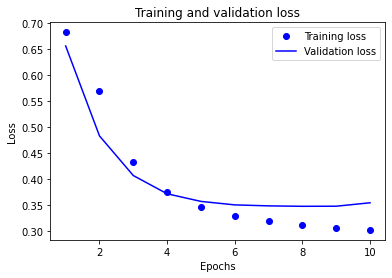

In [27]:
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

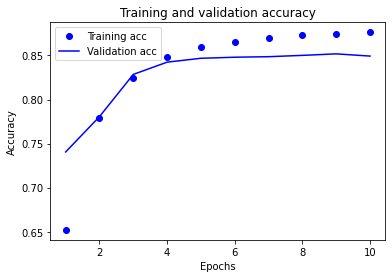

In [28]:
# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1-D Conv

In [29]:
model_1Dconv = keras.Sequential()
model_1Dconv.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1Dconv.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1Dconv.add(keras.layers.MaxPooling1D(5))
model_1Dconv.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_1Dconv.add(keras.layers.GlobalMaxPooling1D())
model_1Dconv.add(keras.layers.Dense(8, activation='relu'))
model_1Dconv.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1Dconv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [30]:
# 모델 학습
model_1Dconv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_1Dconv.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 2s 20ms/step - loss: 0.6901 - accuracy: 0.5717 - val_loss: 0.6780 - val_accuracy: 0.7114
Epoch 2/10
34/34 [==============================] - 0s 10ms/step - loss: 0.6138 - accuracy: 0.7621 - val_loss: 0.5063 - val_accuracy: 0.7996
Epoch 3/10
34/34 [==============================] - 0s 10ms/step - loss: 0.4236 - accuracy: 0.8213 - val_loss: 0.3789 - val_accuracy: 0.8342
Epoch 4/10
34/34 [==============================] - 0s 10ms/step - loss: 0.3489 - accuracy: 0.8524 - val_loss: 0.3517 - val_accuracy: 0.8477
Epoch 5/10
34/34 [==============================] - 0s 10ms/step - loss: 0.3229 - accuracy: 0.8648 - val_loss: 0.3456 - val_accuracy: 0.8514
Epoch 6/10
34/34 [==============================] - 0s 10ms/step - loss: 0.3081 - accuracy: 0.8718 - val_loss: 0.3467 - val_accuracy: 0.8472
Epoch 7/10
34/34 [==============================] - 0s 10ms/step - loss: 0.2979 - accuracy: 0.8763 - val_loss: 0.3443 - val_accuracy: 0.8504
Epoch 8/10
34

In [31]:
# 모델 평가
results = model_1Dconv.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3619 - accuracy: 0.8478
[0.3619474470615387, 0.8477938175201416]


## GlobalMaxPooling

In [32]:
model_maxpool = keras.Sequential()
model_maxpool.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_maxpool.add(keras.layers.GlobalMaxPooling1D())
model_maxpool.add(keras.layers.Dense(8, activation='relu'))
model_maxpool.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_maxpool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [33]:
# 모델 학습
model_maxpool.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_maxpool.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
34/34 [==============================] - 1s 8ms/step - loss: 0.6869 - accuracy: 0.6727 - val_loss: 0.6772 - val_accuracy: 0.7711
Epoch 2/10
34/34 [==============================] - 0s 5ms/step - loss: 0.6591 - accuracy: 0.7901 - val_loss: 0.6353 - val_accuracy: 0.8040
Epoch 3/10
34/34 [==============================] - 0s 5ms/step - loss: 0.6018 - accuracy: 0.8181 - val_loss: 0.5664 - val_accuracy: 0.8185
Epoch 4/10
34/34 [==============================] - 0s 5ms/step - loss: 0.5239 - accuracy: 0.8327 - val_loss: 0.4877 - val_accuracy: 0.8283
Epoch 5/10
34/34 [==============================] - 0s 4ms/step - loss: 0.4481 - accuracy: 0.8425 - val_loss: 0.4254 - val_accuracy: 0.8338
Epoch 6/10
34/34 [==============================] - 0s 4ms/step - loss: 0.3934 - accuracy: 0.8499 - val_loss: 0.3885 - val_accuracy: 0.8378
Epoch 7/10
34/34 [==============================] - 0s 4ms/step - loss: 0.3594 - accuracy: 0.8567 - val_loss: 0.3690 - val_accuracy: 0.8409
Epoch 8/10
34/34 [==

In [34]:
# 모델 평가
results = model_maxpool.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3620 - accuracy: 0.8413
[0.3619559705257416, 0.8413247466087341]


In [35]:
import gensim
word2vec_path = os.getenv('HOME') +'/aiffel/workplace/E-06_Movie_Review/sentiment_classification/data/ko.bin'
pre_word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = pre_word2vec.wv.most_similar("강아지")
vector

[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

In [36]:
pre_word2vec['강아지'].shape

/tmp/ipykernel_740/3111700179.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  pre_word2vec['강아지'].shape


(200,)

In [37]:
# 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in pre_word2vec:
        embedding_matrix[i] = pre_word2vec[index_to_word[i]]

/tmp/ipykernel_740/2169394076.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in pre_word2vec:
/tmp/ipykernel_740/2169394076.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = pre_word2vec[index_to_word[i]]


In [38]:
# 모델 설계
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [39]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
34/34 [==============================] - 2s 33ms/step - loss: 0.6527 - accuracy: 0.6100 - val_loss: 0.5990 - val_accuracy: 0.6807
Epoch 2/15
34/34 [==============================] - 1s 20ms/step - loss: 0.5396 - accuracy: 0.7321 - val_loss: 0.4778 - val_accuracy: 0.7758
Epoch 3/15
34/34 [==============================] - 1s 20ms/step - loss: 0.4361 - accuracy: 0.8015 - val_loss: 0.4040 - val_accuracy: 0.8168
Epoch 4/15
34/34 [==============================] - 1s 20ms/step - loss: 0.3774 - accuracy: 0.8361 - val_loss: 0.3738 - val_accuracy: 0.8336
Epoch 5/15
34/34 [==============================] - 1s 20ms/step - loss: 0.3441 - accuracy: 0.8543 - val_loss: 0.3580 - val_accuracy: 0.8435
Epoch 6/15
34/34 [==============================] - 1s 20ms/step - loss: 0.3220 - accuracy: 0.8653 - val_loss: 0.3527 - val_accuracy: 0.8470
Epoch 7/15
34/34 [==============================] - 1s 20ms/step - loss: 0.3070 - accuracy: 0.8729 - val_loss: 0.3506 - val_accuracy: 0.8473
Epoch 8/15
34

In [40]:
# 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3678 - accuracy: 0.8474
[0.3678380846977234, 0.8474276065826416]


In [41]:
# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [42]:
# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

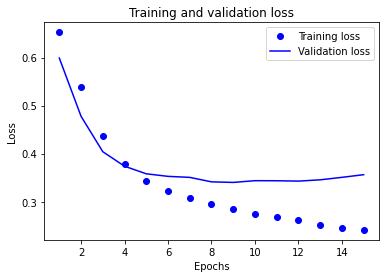

In [43]:
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

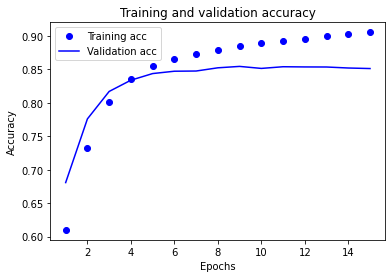

In [44]:
# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

자연어 처리에 대해서 정말 시작 할 수 있을정도의 감을 잡은 것 같다. 자연어 처리가 생각보다 재미 있다는 생각을 했다.  
단어간의 단편적인 유사도와 문법적인 관계 뿐만 아니라. 개인의 해당 단어에 대한 사상도 투영시킬 수 있을 것 같다는 생각을 했다.  
어차피 개인의 경험은 사람마다 전부 다 다르고 단어에 대한 경험도 사람마다 다 다르기 때문에 우리가 어떤 단어를 받아들일때 느끼는 느낌은 전부 다르다고 생각한다.  
그러한 단어와 연결된 개개인의 이미지들, 느낌들을 벡터로 표현해서 학습 시킨다면 또다른 재미 있는 결과를 도출 할  수 있을 것이라는 생각이 든다.  
이부분은 아이펠을 하는 동안 꾸준하게 한번 고민해보고 연구해봐야 할 주제로 삼으면 좋겠다는 생각을 했다.

사실 구현하는데 급급해서 역시 여기저기서 컨닝하고 지식을 얻어 오는데 급급한 익스였다. 
언제쯤 완벽하게 나의 생각과 계획대로 진행할 수 있을지는 모르지만 일단 전반적인 프로세스들을 이해 할 수 있다는 것으로 만족한다.  
일단 촉박한 시간 때문에 전처리를 진행하지 못했다. 아래에는 진행하고 있는 전처리들을 빼놓은 상태이다.  
시간이 된다면 전처리까지 해서 성능이 얼마나 개선되는지 확인하고 싶다. 만약에 그렇지 못하더라도 주말즘에는 전처리를 진행하고 테스트를 해볼 예정이다.  

매일 프로젝트를 마무리 할 때 마다 해보고 싶은 것은 많지만 해보지 못하는 것들에 대한 후회가 밀려온다.  
시간이 지나면 조금 괜찮아 질까?

## 중복데이터 제거

- ### pandas의 unique(), value_counts() 함수는 유일한 값을 찾거나, 유일한 값별로 개수를 세준다.

### train_data 의 중복개수 확인

In [29]:
# train_data의 'document' 컬럼의 내용 확인, 10개만 확인해보자
train_data['document'].head(10)

0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
5        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
6                                원작의 긴장감을 제대로 살려내지못했다.
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?
Name: document, dtype: object

time: 3.11 ms (started: 2022-01-23 10:59:18 +00:00)


In [30]:
# document에 있는 내용의 수
len(train_data['document'])

150000

time: 4.24 ms (started: 2022-01-23 10:59:23 +00:00)


In [31]:
# document에 있는 유니크한 내용의 수
len(train_data['document'].value_counts())

146182

time: 85.1 ms (started: 2022-01-23 10:59:24 +00:00)


In [32]:
# 중복 개수 확인
result1 = len(train_data['document']) - len(train_data['document'].value_counts())
result1

3818

time: 78.1 ms (started: 2022-01-23 10:59:26 +00:00)


### test_data의 중복개수 확인

In [33]:
# test_data의 'document' 컬럼의 내용 확인, 10개만 확인해보자
test_data['document'].head(10)

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2               뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                     지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4    3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
5                                   음악이 주가 된, 최고의 음악영화
6                                              진정한 쓰레기
7             마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다
8    갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...
9       이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..
Name: document, dtype: object

time: 3.83 ms (started: 2022-01-23 10:59:28 +00:00)


In [34]:
len(test_data['document'])

50000

time: 1.82 ms (started: 2022-01-23 10:59:30 +00:00)


In [35]:
len(test_data['document'].value_counts())

49157

time: 23.9 ms (started: 2022-01-23 10:59:32 +00:00)


In [36]:
result2 = len(test_data['document']) - len(test_data['document'].value_counts())
result2

843

time: 23.3 ms (started: 2022-01-23 10:59:35 +00:00)


### 중복 데이터 제거

중복 제거
중복을 제거하기 위해서는 내장함수를 활용하거나 pandas를 활용할 수 있다.  
내장함수에는 set(순서 중요하지 않을때)을 사용하거나 for문으로 요소를 확인 후 append하는 방식을 적용할 수 있다.  
본 프로젝트에서는 drop_duplicates 함수를 사용했다.

### train_data 중복 데이터 제거, inplace=True 데이터 프레임에 덮어 씌운다

In [37]:
# 중복데이터는 가공한 주요 데이터가 들어 있는 document 열을 기준으로 진행한다.
train_data.drop_duplicates(['document'],inplace = True)

time: 52.1 ms (started: 2022-01-23 10:59:37 +00:00)


In [38]:
# 원래 150,000개에서 146,183개로 줄어 들었다.
len(train_data['document'])

146183

time: 4.15 ms (started: 2022-01-23 10:59:39 +00:00)


### test_data 중복 데이터 제거, inplace=True 데이터 프레임에 덮어 씌운다

In [39]:
test_data.drop_duplicates(['document'],inplace = True)

time: 16.3 ms (started: 2022-01-23 10:59:42 +00:00)


In [40]:
# 원래 50,000개에서 49,158개로 줄어 들었다.
len(test_data['document'])

49158

time: 2.2 ms (started: 2022-01-23 10:59:45 +00:00)


## 특수문자 제거

- ㄱ ~ ㅎ: 3131 ~ 314E, ㅏ ~ ㅣ: 314F ~ 3163이며 완성형 한글의 범위는 가 ~ 힣을 사용한다.
- 한글과 공백을 제외하고 모두 제거하는 정규화를 시도한다.

In [44]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:10]

/tmp/ipykernel_13/3683645933.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


time: 133 ms (started: 2022-01-23 11:01:11 +00:00)


## NaN 결측치 제거 (추후 더 정확한 확인 필요)

In [52]:
# train_data의 각 컬럼별 결측치 수량
for col in train_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          train_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개
time: 15.8 ms (started: 2022-01-23 11:07:44 +00:00)


In [53]:
# test_data의 각 컬럼별 결측치 수량
for col in test_data.columns:
    print('column: {:>10}\t NULL value 개수: {}개'.format(col, 
          test_data[col].isnull().sum()))

column:         id	 NULL value 개수: 0개
column:   document	 NULL value 개수: 1개
column:      label	 NULL value 개수: 0개
time: 5.59 ms (started: 2022-01-23 11:07:45 +00:00)


In [ ]:
결측치가 한개 존재 하는 것으로 확인 되었다.  
결측치의 개수는 1개 밖에 안되기 때문에 별 영향을 미치지 않을 것으로 판단되어 제거 한다.